In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 18 08:32:04 2020

@author: mto
"""

from osa import Client
import numpy as np
import matplotlib.pyplot as plt

srv = Client('http://esb:8280/services/FieldLineProxy?wsdl')

#################
# Coil currents #
#################
I1 = 13524 # values from ArchiveDB or experiment logbook
I2 = 13145  
I3 = 12524
I4 = 11897
I5 = 11526
IA = 0
IB = 0
Ioff = 0 # Offset current in planar coils I(A,B) for iota-correction, determined from FSM 

# Itc-Stromwerte invertiert, um Situation ohne aktive b11-Feldfehlerkompensation zu simulieren
Itc1 =  81
Itc2 = -33
Itc3 = -100
Itc4 = -33
Itc5 =  81
Itc=[Itc1, Itc2, Itc3, Itc4, Itc5]

# Icc-Stromwerte invertiert, um Situation ohne aktive b22-Feldfehlerkompensation zu simulieren
Icc1 =  531.77449638
Icc2 =  378.90750231
Icc3 = -255.17636576
Icc4 = -269.13820556
Icc5 =  102.6648061
Icc6 =   -1.31131196
Icc7 =  300.85974959
Icc8 =  401.6726024
Icc9 = -391.2362153
Icc10 =-483.75262189
Icc=[Icc1, Icc2, Icc3, Icc4, Icc5, Icc6, Icc7, Icc8, Icc9, Icc10]
Icc_r = [round(num, 0) for num in Icc]

config = srv.types.MagneticConfig()

###########################################################################
#           Definition of coil types from data base                       #
# http://webservices.ipp-hgw.mpg.de/docs/fieldlinetracer.html#searchCoils #
###########################################################################
# Ideal non-planar, planar, conntrol(sweep) and trim coils
config.coilsIds = np.arange(160, 240) # 50x NPC, 20x PC, 10x CC
config.coilsIds = np.append(config.coilsIds, [350, 241, 351, 352, 353]) # 5x TC

###############################################################################
# Definition of the coil currents, sign for IDEAL COILS (!)
# Magnetic configuration acc. PLM document 1-AA-T0011
# Winding coil current (I[A] x n) for non-planar and planar coils 
# Sign of the winding currents for positive field direction acc. 1-AA-R0004
# I1-I5: "-"
# IA-IB: "-"
# Icc1, Icc2, ..., Icc9, Icc10: "+", "-", ..., "+", "-"
# It1-It5: "+"
###############################################################################
config.coilsIdsCurrents = [-I1*108, -I2*108, -I3*108, -I4*108, -I5*108]*10
config.coilsIdsCurrents.extend([-(IA-Ioff)*36, -(IB-Ioff)*36]*10)
config.coilsIdsCurrents.extend([Icc1*8, -Icc2*8, Icc3*8, -Icc4*8, Icc5*8, -Icc6*8, Icc7*8, -Icc8*8, Icc9*8, -Icc10*8])
config.coilsIdsCurrents.extend([Itc1*48, Itc2*72, Itc3*48, Itc4*48, Itc5*48])
'''

###########################################################################
#           Definition of coil types from data base                       #
# http://webservices.ipp-hgw.mpg.de/docs/fieldlinetracer.html#searchCoils #
###########################################################################
# Non-ideal non-planar and ideal planar but ideal conntrol(sweep) and trim coils
config.coilsIds = np.arange(1292, 1362) # 50x NPC, 20x PC
config.coilsIds = np.append(config.coilsIds, [230, 231, 232, 233, 234, 235, 236, 237, 238, 239]) # 10x CC
config.coilsIds = np.append(config.coilsIds, [350, 241, 351, 352, 353]) # 5x TC

###############################################################################
# Definition of the coil currents, sign for IDEAL COILS (!)
# Magnetic configuration acc. PLM document 1-AA-T0011
# Winding coil current (I[A] x n) for non-planar and planar coils 
# Sign of the winding currents for positive field direction acc. 1-AA-R0004
# I1-I5: "-"
# IA-IB: "-"
# Icc1, Icc2, ..., Icc9, Icc10: "+", "-", ..., "+", "-"
# It1-It5: "+"
###############################################################################
config.coilsIdsCurrents = [I1*108, I2*108, I3*108, I4*108, I5*108]*10
config.coilsIdsCurrents.extend([(IA+Ioff)*36, (IB+Ioff)*36]*10)
config.coilsIdsCurrents.extend([Icc1*8, -Icc2*8, Icc3*8, -Icc4*8, Icc5*8, -Icc6*8, Icc7*8, -Icc8*8, Icc9*8, -Icc10*8])
config.coilsIdsCurrents.extend([Itc1*48, Itc2*72, Itc3*48, Itc4*48, Itc5*48])
'''

#######################
# Magnetic field grid #
#######################
print("Calculating B-field grid ...")
grid = srv.types.Grid()
config.grid = grid
grid.fieldSymmetry = 1
cyl = srv.types.CylindricalGrid()
grid.cylindrical = cyl
cyl.numR, cyl.numZ, cyl.numPhi = 181, 181, 481
cyl.RMin, cyl.RMax, cyl.ZMin, cyl.ZMax = 4.05, 6.75, -1.35, 1.35

#######################################
# Geometrical limits of machine  grid #
#######################################
machine = srv.types.Machine(1)
machine.grid.numX, machine.grid.numY, machine.grid.numZ = 500, 500, 100
machine.grid.ZMin, machine.grid.ZMax = -1.5, 1.5
machine.grid.YMin, machine.grid.YMax = -7, 7
machine.grid.XMin, machine.grid.XMax = -7, 7
machine.meshedModelsIds = [164, 161] # 164 = rectangular torus, 161 = Abschirmhaus
# machine.assemblyIds = [1, 4, 5] # 1 = plasma vessel, 4 = divertor, 5 = baffle
machine.assemblyIds = [1] # 1 = plasma vessel, 4 = divertor, 5 = baffle

####################
# Defaults for FLT #
####################
# phi0 = 0.0*(2.0*np.pi/360.0) # Bean shaped plane 
phi0 = 108.0*(2.0*np.pi/360.0) # Triangular shaped plane 
task = srv.types.Task()
task.step = 0.01

#############################
# Calculating flux surfaces #
#############################
print("Calculating flux surfaces ...")
pos = srv.types.Points3D()
pos.x1 = np.linspace(6.175, 6.182, 10)
pos.x2 = np.zeros(10)
pos.x3 = np.zeros(10)
poincare = srv.types.PoincareInPhiPlane()
poincare.numPoints = 10000
poincare.phi0 = np.linspace(0, 2*np.pi, 1, endpoint=0)+phi0 # n times in toroidal direction --> for 5 symmetry
task.poincare = poincare
res = srv.service.trace(pos, config, task, machine, None)

URLError: <urlopen error [Errno -2] Name or service not known>

Number of flux surfaces: 10


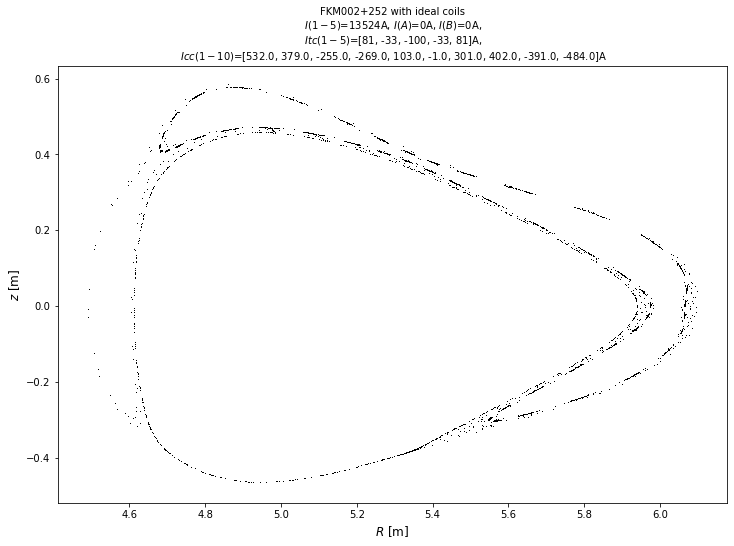

In [5]:
print("Number of flux surfaces: " + str(len(res.surfs)))
plt.figure(figsize=(10.3,10.3))
for i in res.surfs:
    x = np.array(i.points.x1)    
    y = np.array(i.points.x2)
    z = np.array(i.points.x3)
    R = np.sqrt(x**2 + y**2)    
    plt.axes().set_aspect('equal')
    plt.xlabel(r"$R$ [m]", fontsize=12)
    plt.ylabel(r"$z$ [m]", fontsize=12)    
    plt.title("FKM002+252 with ideal coils\n $I(1-5)$="+str(I1)+"A, $I(A)$="+str(IA)+"A, $I(B)$="+str(IB)+"A, \n $Itc(1-5)$="+str(Itc)+"A, \n $Icc(1-10)$="+str(Icc_r)+"A", fontsize=10)
    plt.tight_layout()    
    plt.plot(R, z, ",k", ms = 0.5)
plt.savefig("22-Errorfield-Example.pdf", format='PDF')